In [1]:

%load_ext autoreload
%autoreload 2
import sys
import os
workarea = os.environ.get("WORKAREA")

sys.path.insert(0,workarea)


import torch
from torch_geometric.data import Data

def create_grid_graph(rows, cols, num_channels):
    num_nodes = rows * cols
    edge_index = []
    
    for i in range(rows):
        for j in range(cols):
            node = i * cols + j
            if j < cols - 1:
                edge_index.append([node, node + 1])
            if i < rows - 1:
                edge_index.append([node, node + cols])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.rand((edge_index.size(1), num_channels), dtype=torch.float)
    
    x = torch.rand((num_nodes, num_channels), dtype=torch.float)
    grid_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return grid_data

def create_mesh_graph(num_nodes, num_channels):
    edge_index = []
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_index.append([i, j])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.rand((edge_index.size(1), num_channels), dtype=torch.float)
    
    x = torch.rand((num_nodes, num_channels), dtype=torch.float)
    mesh_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return mesh_data

def create_g2m_and_m2g_connections(grid_data, mesh_data, num_channels):
    grid_nodes = grid_data.num_nodes
    mesh_nodes = mesh_data.num_nodes
    
    g2m_edge_index = torch.stack([torch.randint(0, grid_nodes, (mesh_nodes,)),
                                  torch.arange(0, mesh_nodes)], dim=0)
    
    m2g_edge_index = torch.stack([torch.arange(0, mesh_nodes),
                                  torch.randint(0, grid_nodes, (mesh_nodes,))], dim=0)
    
    g2m_edge_attr = torch.rand((g2m_edge_index.size(1), num_channels), dtype=torch.float)
    m2g_edge_attr = torch.rand((m2g_edge_index.size(1), num_channels), dtype=torch.float)
    
    return g2m_edge_index, g2m_edge_attr, m2g_edge_index, m2g_edge_attr

def create_custom_graph_dataset(grid_rows, grid_cols, mesh_nodes, num_channels, edge_dim):
    grid_data = create_grid_graph(grid_rows, grid_cols, num_channels)
    mesh_data = create_mesh_graph(mesh_nodes, num_channels)
    
    g2m_edge_index, g2m_edge_attr, m2g_edge_index, m2g_edge_attr = create_g2m_and_m2g_connections(grid_data, mesh_data, edge_dim)
    
    combined_x = torch.cat([grid_data.x, mesh_data.x], dim=0)
    
    mesh_edge_index_shifted = mesh_data.edge_index + grid_data.num_nodes
    
    data = Data(
        x=combined_x,
        g2m_edge_index=g2m_edge_index + torch.tensor([[0], [grid_data.num_nodes]], dtype=torch.long),
        g2m_edge_attr=g2m_edge_attr,
        m2m_edge_index=mesh_edge_index_shifted,
        m2m_edge_attr=mesh_data.edge_attr,
        m2g_edge_index=m2g_edge_index + torch.tensor([[grid_data.num_nodes], [0]], dtype=torch.long),
        m2g_edge_attr=m2g_edge_attr
    )
    
    return data

dataset = create_custom_graph_dataset(
    grid_rows=2,
    grid_cols=2,
    mesh_nodes=4,
    num_channels=32,  # Node feature dimension
    edge_dim=32  # Edge feature dimension
)



In [2]:

import torch

from sdk.ample import Ample

from torch_geometric.datasets import FakeDataset #TODO remove
from sdk.models.models import MLP_Model,Interaction_Net_Model,GCN_Model

from torch_geometric.data import Data


class Graphcast(torch.nn.Module):
    def __init__(self, in_channels=32, out_channels=32, layer_count=1, hidden_dimension=32, precision = torch.float32):
        super().__init__()
        self.precision = precision
        self.layers = torch.nn.ModuleList()
       
        self.grid_mesh_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.grid_mesh_embedder.name  = 'grid_mesh_embedder'
        self.layers.append(self.grid_mesh_embedder) 

        self.g2m_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.g2m_embedder.name  = 'g2m_embedder'
        self.layers.append(self.g2m_embedder) 

        self.g2m_int_net = Interaction_Net_Model()
        self.g2m_int_net.name  = 'g2m_int_net'
        self.layers.append(self.g2m_int_net) 

        self.m2m_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.m2m_embedder.name  = 'm2m_embedder'
        self.layers.append(self.m2m_embedder) 

        self.m2m_int_net = Interaction_Net_Model()
        self.m2m_int_net.name  = 'm2m_int_net'
        self.layers.append(self.m2m_int_net) 

        self.m2g_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.m2g_embedder.name  = 'm2m_embedder'
        self.layers.append(self.m2g_embedder) 
 
        self.m2g_int_net = Interaction_Net_Model()
        self.m2g_int_net.name  = 'm2m_int_net'
        self.layers.append(self.m2g_int_net) 
        
        for layer in self.layers:
            layer.to(self.precision)


        #   g2m_edge_attr,
        #   g2m_edge_index,
        #   grid_mesh_rep,
        #   m2m_edge_attr,
        #   m2m_edge_index]
    def forward(
            self,
            g2m_edge_attr,
            g2m_edge_index,
            grid_mesh_rep,
            m2m_edge_attr,
            m2m_edge_index
            # m2g_edge_attr,
            # m2g_edge_index
            ):
            
        outputs_model = []
        
        outputs_sub_model1,grid_mesh_emb = self.grid_mesh_embedder(grid_mesh_rep)
        
        outputs_sub_model2,g2m_emb = self.g2m_embedder(g2m_edge_attr)

        outputs_sub_model3,grid_mesh_emb = self.g2m_int_net(grid_mesh_emb, g2m_edge_index, g2m_emb)
        
        # outputs_sub_model4,m2m_emb = self.m2m_embedder(m2m_edge_attr)

        outputs_sub_model5,grid_mesh_emb = self.m2m_int_net(grid_mesh_emb, m2m_edge_index,g2m_emb)

        # outputs_sub_model6,m2g_emb = self.m2g_embedder(m2g_edge_attr)

        outputs_sub_model7,grid_mesh_emb = self.m2g_int_net(grid_mesh_emb, g2m_edge_index,g2m_emb)

        outputs_model = outputs_sub_model1 + outputs_sub_model2 + outputs_sub_model3 + outputs_sub_model5 + outputs_sub_model7# + outputs_sub_model4  #+ outputs_sub_model6 #+ outputs_sub_model7
        return outputs_model,grid_mesh_emb



/home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = Graphcast()


print('grid_mesh_rep',dataset.x)
print('g2m_edge_attr',dataset.g2m_edge_attr)
# print('m2m_edge_attr',dataset.m2m_edge_attr)
# print('m2g_edge_attr',dataset.m2g_edge_attr)
print('g2m_edge_index',dataset.g2m_edge_index)
# print('m2m_edge_index',dataset.m2m_edge_index)
# print('m2g_edge_index',dataset.m2g_edge_index)


print('grid_mesh_rep',dataset.x.shape)
print('g2m_edge_attr',dataset.g2m_edge_attr.shape)
# print('m2m_edge_attr',dataset.m2m_edge_attr.shape)
# print('m2g_edge_attr',dataset.m2g_edge_attr.shape)
print('g2m_edge_index',dataset.g2m_edge_index.shape)
# print('m2m_edge_index',dataset.m2m_edge_index.shape)
# print('m2g_edge_index',dataset.m2g_edge_index.shape)

grid_mesh_rep = dataset.x
g2m_edge_attr = dataset.g2m_edge_attr
m2m_edge_attr = dataset.m2m_edge_attr
m2g_edge_attr = dataset.m2g_edge_attr
g2m_edge_index = dataset.g2m_edge_index
m2m_edge_index = dataset.m2m_edge_index
m2g_edge_index = dataset.m2g_edge_index

# inputs  = [g2m_edge_attr, m2m_edge_attr, m2g_edge_attr, g2m_edge_index, m2m_edge_index, m2g_edge_index, grid_mesh_rep]
inputs = [
          g2m_edge_attr,
          g2m_edge_index,
          grid_mesh_rep,
          m2m_edge_attr,
          m2m_edge_index]


dataset = FakeDataset(
                        num_graphs=1, 
                        avg_num_nodes = 32,
                        avg_degree=3,
                        num_channels=32,
                        edge_dim=32
                    )[0]



#IMPORTANT: The order of the inputs in the forward function must match the order of the external inputs identified by the compiler


inputs = [dataset.edge_attr,
          dataset.edge_index,
          dataset.x,
          (dataset.edge_attr + 0.1),
          dataset.edge_index]
outputs_model, grid_mesh_emb = model(*inputs)

grid_mesh_rep tensor([[0.4184, 0.5154, 0.6579, 0.6648, 0.9783, 0.9891, 0.5881, 0.8167, 0.4930,
         0.3628, 0.7621, 0.8813, 0.2480, 0.6209, 0.9082, 0.6812, 0.5224, 0.2789,
         0.4586, 0.7575, 0.9775, 0.1681, 0.7716, 0.1593, 0.1185, 0.4155, 0.8240,
         0.0626, 0.3561, 0.5692, 0.8909, 0.6905],
        [0.5852, 0.5004, 0.5232, 0.2161, 0.7983, 0.3837, 0.6373, 0.1817, 0.8794,
         0.2690, 0.1938, 0.0229, 0.3417, 0.2711, 0.7093, 0.4983, 0.0900, 0.0816,
         0.9646, 0.2232, 0.1250, 0.0048, 0.7136, 0.0952, 0.0667, 0.6315, 0.8770,
         0.0900, 0.4638, 0.9733, 0.5464, 0.4664],
        [0.8888, 0.4218, 0.1482, 0.3282, 0.1451, 0.6340, 0.2802, 0.8555, 0.5380,
         0.4823, 0.8720, 0.1097, 0.0330, 0.6478, 0.1508, 0.6130, 0.4024, 0.1414,
         0.1628, 0.9943, 0.9853, 0.1380, 0.6273, 0.2291, 0.7108, 0.7834, 0.3923,
         0.6201, 0.6269, 0.5141, 0.8977, 0.9276],
        [0.9236, 0.5566, 0.7366, 0.7786, 0.1809, 0.2409, 0.6570, 0.6242, 0.1059,
         0.1074, 0.9030, 0

Rendering graph...


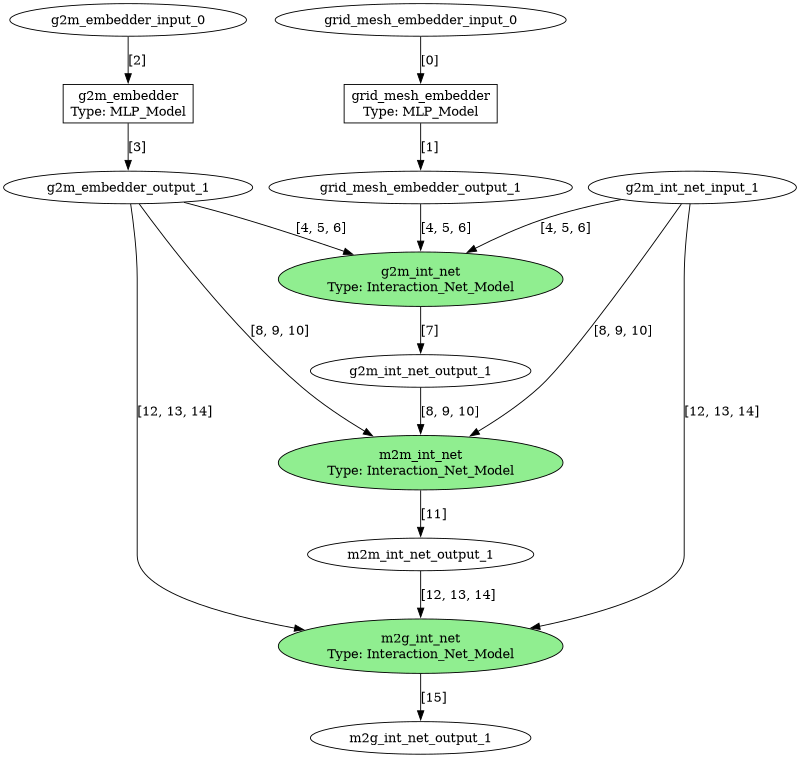

Ensure inputs match the following list {'g2m_embedder_input_0': None, 'g2m_int_net_input_1': None, 'grid_mesh_embedder_input_0': None}
Sub model grid_mesh_embedder has inputs from ['grid_mesh_embedder_input_0']
Sub model g2m_embedder has inputs from ['g2m_embedder_input_0']
Sub model g2m_int_net has inputs from ['grid_mesh_embedder_output_1', 'g2m_int_net_input_1', 'g2m_embedder_output_1']
Sub model m2m_int_net has inputs from ['g2m_int_net_output_1', 'g2m_int_net_input_1', 'g2m_embedder_output_1']
Sub model m2g_int_net has inputs from ['m2m_int_net_output_1', 'g2m_int_net_input_1', 'g2m_embedder_output_1']


5it [00:00, 26051.58it/s]
23it [00:00, 51698.28it/s]
5it [00:00, 33716.27it/s]
23it [00:00, 50218.11it/s]
5it [00:00, 34211.29it/s]
23it [00:00, 54874.28it/s]
5it [00:00, 32463.65it/s]
23it [00:00, 53534.40it/s]
/home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/torch/jit/_trace.py:1088: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


In [4]:
from sdk.ample import Ample
ample = Ample(sim=True,cpu_sim=True)
model.to_device('ample',data=inputs)

In [5]:
out = model(*inputs)

args Namespace(cpu=True, gpu=False, sim=True, fpga_clk_freq=200000000.0, device=0, preload=False, tb_tolerance=0.01, tb_log_level='INFO', build=False, gui=False, metrics=False)
base path /home/aw1223/ip/agile/
cd /home/aw1223/ip/agile/hw/sim
==== Running command: cd /home/aw1223/ip/agile/hw/sim; make run_sim
make -f Makefile.modelsim run_sim
make[1]: Entering directory '/home/aw1223/ip/agile/hw/sim'
set -o pipefail; LIBPYTHON_LOC=/home/aw1223/anaconda3/envs/ample/lib/libpython3.11.so.1.0 MODULE=runner TESTCASE= TOPLEVEL="work.top_wrapper" \
GPI_EXTRA= TOPLEVEL_LANG=verilog \
 /mnt/applications/mentor/modelsim-2019.2/modelsim/modeltech/linux_x86_64/vsim -c -64 -l sim_build/modelsim.log -onfinish exit -do sim_build/../simulate_no_gui.do -quiet -suppress vsim-3015  -pli /home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/cocotb/libs/libcocotbvpi_modelsim.so \
 \
work.work_opt \
 2>&1 | tee sim_build/simulate.log
/mnt/applications/mentor/modelsim-2019.2/modelsim/modeltech/linux_